In [1]:
import sys
sys.path.append('../')
from src.scoring_functions import *
from src.load_data import *
from plotnine import *

In [2]:
# from darts import TimeSeries
# from darts.utils.missing_values import fill_missing_values
# from darts.utils.statistics import plot_acf, plot_ccf, plot_pacf

In [3]:
import xarray as xr
from scores.stats import statistical_tests

In [4]:
from itertools import combinations

In [5]:
def custom_theme():
    return theme(
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),           
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8, rotation=90, ha='center', ma='right'),
        axis_text_y=element_text(size=8)
    )

In [6]:
MODEL_COLORS = {
    'Ensemble': '#009E73',
    'LightGBM': '#B30000',
    'LightGBM-NoCovariates': '#B30000',
    'LightGBM-NoCovid': '#B30000',
    'LightGBM-Oracle': '#B30000',
    'LightGBM-Skip': '#B30000',
    'LightGBM-Uncorrected': '#B30000',
    'TSMixer': '#E69F00',
    'TSMixer-NoCovariates': '#E69F00',
    'TSMixer-NoCovid': '#E69F00',
    'TSMixer-Oracle': '#E69F00',
    'TSMixer-Skip': '#E69F00',
    'TSMixer-Uncorrected': '#E69F00',
    'hhh4': '#3C4AAD',
    'hhh4-NoCovid': '#3C4AAD',
    'hhh4-Oracle': '#3C4AAD',
    'hhh4-Skip': '#3C4AAD',
    'hhh4-Uncorrected': '#3C4AAD',
    'Nowcast': '#56B4E9',
    'Historical': '#000000',
    'Persistence' : '#80471C',
}

In [7]:
MODEL_ORDER = ['Nowcast', 'Ensemble', 
               'LightGBM', 'LightGBM-NoCovariates', 'LightGBM-NoCovid', 'LightGBM-Oracle', 'LightGBM-Skip', 'LightGBM-Uncorrected',
               'TSMixer', 'TSMixer-NoCovariates', 'TSMixer-NoCovid', 'TSMixer-Oracle', 'TSMixer-Skip', 'TSMixer-Uncorrected',
               'hhh4', 'hhh4-NoCovid', 'hhh4-Oracle', 'hhh4-Skip', 'hhh4-Uncorrected', 'Persistence', 'Historical']

In [8]:
MAIN_MODEL_ORDER = ['Ensemble', 'LightGBM', 'TSMixer', 'hhh4', 'Persistence', 'Historical']

In [9]:
MAIN_MODELS = ['Ensemble', 'LightGBM', 'TSMixer', 'hhh4', 'Historical', 'Persistence']

In [10]:
df = load_predictions()

In [11]:
df.model.unique()

array(['LightGBM-NoCovid', 'TSCount-NB-S', 'LightGBM-NoCovariates',
       'LightGBM-Skip', 'LightGBM', 'LightGBM-Uncorrected', 'Historical',
       'Persistence', 'LightGBM-Oracle', 'TSCount-Pois', 'TSMixer',
       'TSMixer-Oracle', 'hhh4-Uncorrected', 'TSMixer-NoCovariates',
       'TSMixer-Uncorrected', 'hhh4', 'hhh4-Skip', 'Ensemble',
       'hhh4-NoCovid', 'TSMixer-NoCovid', 'TSMixer-Skip', 'hhh4-Oracle'],
      dtype=object)

In [12]:
df = df[df.model.isin(MAIN_MODELS)].copy()
model_order = [m for m in MODEL_ORDER if m in df.model.unique()]
df['model'] = pd.Categorical(df['model'], categories=model_order, ordered=True) 

In [14]:
def compute_wis_raw(df):
    # Filter rows where 'quantile' is 0.5, rename 'value' to 'med', and drop unnecessary columns
    df_median = df[df['quantile'] == 0.5].copy()
    df_median = df_median.rename(columns={'value': 'med'}).drop(columns=['quantile', 'pathogen', 'retrospective', 'truth'], errors='ignore')

    # Filter rows where 'type' is 'quantile' and merge with df_median
    df_quantile = df[df['type'] == 'quantile'].copy()
    df = df_quantile.merge(df_median, how='left')

    # Compute scores and other metrics row-wise
    df['wis'] = df.apply(lambda row: score(row['value'], row['truth'], row['type'], row['quantile']), axis=1)
    df['spread'] = df.apply(lambda row: score(row['value'], row['med'], row['type'], row['quantile']), axis=1)
    df['overprediction'] = df.apply(lambda row: row['wis'] - row['spread'] if row['med'] > row['truth'] else 0, axis=1)
    df['underprediction'] = df.apply(lambda row: row['wis'] - row['spread'] if row['med'] < row['truth'] else 0, axis=1)
    
    return df

In [15]:
df_national = filter_by_level(df, 'national')

In [16]:
df_wis = compute_wis_raw(df_national)

In [17]:
df = df_wis.groupby(['location', 'age_group', 'model', 'date', 'horizon'], observed=True)['wis'].mean().reset_index()

In [18]:
df.head(6)

,location,age_group,model,date,horizon,wis
0,DE,00+,Ensemble,2023-11-19,1,459.502109
1,DE,00+,Ensemble,2023-11-26,1,495.113558
2,DE,00+,Ensemble,2023-11-26,2,566.396375
3,DE,00+,Ensemble,2023-12-03,1,626.412297
4,DE,00+,Ensemble,2023-12-03,2,621.045480
5,DE,00+,Ensemble,2023-12-03,3,671.003474


In [19]:
df.date = pd.to_datetime(df.date)

In [21]:
df_results = pd.DataFrame()
for m1, m2 in combinations(MAIN_MODEL_ORDER, 2):
    print(f'{m1} vs {m2}')
    df_temp = df[df.model.isin([m1, m2])]
    df_temp = df_temp.pivot(index=['location', 'age_group', 'date', 'horizon'], 
                        columns='model', values='wis').rename_axis(columns=None).reset_index()
    df_temp['score_diff'] = df_temp[m1] - df_temp[m2]
    df_temp = (df_temp
               .pivot(index="date", columns="horizon", values="score_diff")
               .rename_axis(index="valid_date")      
               .sort_index()
              )

    da = xr.DataArray(
        data=df_temp.T.to_numpy(),              
        dims=["horizon", "valid_date"],
        coords={
            "horizon": df_temp.columns.astype(int),
            "valid_date": ("valid_date", pd.to_datetime(df_temp.index)),
            "h": ("horizon", df_temp.columns.astype(int))
        },
        name="score_diff"
    )
    
    results = statistical_tests.diebold_mariano(da, ts_dim="horizon", h_coord="h")
    results = results[['horizon', 'confidence_gt_0']].to_pandas().reset_index()
    results['m1'] = m1
    results['m2'] = m2
    df_results = pd.concat([df_results, results], ignore_index=True)

Ensemble vs LightGBM


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.


Ensemble vs TSMixer
Ensemble vs hhh4


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.


Ensemble vs Persistence
Ensemble vs Historical


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.


LightGBM vs TSMixer
LightGBM vs hhh4


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.


LightGBM vs Persistence


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.


LightGBM vs Historical
TSMixer vs hhh4


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.


TSMixer vs Persistence
TSMixer vs Historical
hhh4 vs Persistence


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.


hhh4 vs Historical
Persistence vs Historical


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/scores/stats/statistical_tests/diebold_mariano_impl.py:253: RuntimeWarning: A least one NaN value was detected in `da_timeseries`. This may impact the calculation of autocovariances.


In [22]:
df_results = df_results.rename(columns={'confidence_gt_0' : 'pval'})

df_results['pval_two_sided'] = 2 * np.minimum(df_results['pval'], 1 - df_results['pval'])

In [23]:
d1 = df_results.copy()

In [24]:
d1['m1'] = pd.Categorical(d1['m1'], categories=MODEL_ORDER, ordered=True)
d1['m2'] = pd.Categorical(d1['m2'], categories=MODEL_ORDER[::-1], ordered=True)

In [25]:
d1['sig'] = d1['pval_two_sided'] < 0.05

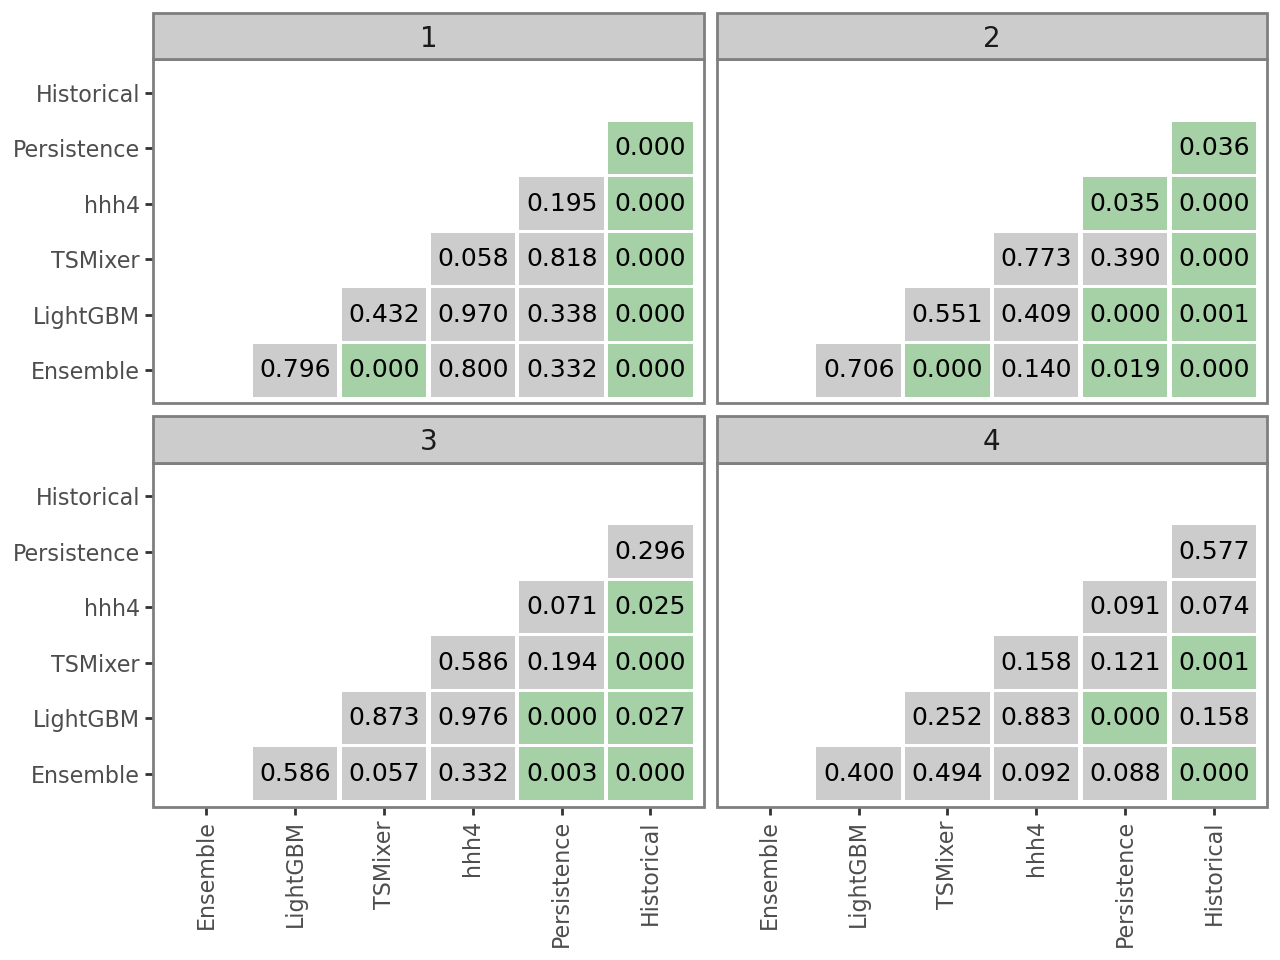

In [26]:
p = (
    ggplot(d1, aes('m2', 'm1'))
    + facet_wrap('horizon', ncol=2)
    + geom_tile(aes(fill='sig'), width=0.95, height=0.95, alpha=0.4, show_legend=False)
    + geom_text(aes(label='pval_two_sided'), format_string='{:.3f}', size=9)
    + scale_fill_manual(values={True:'#228B22', False:'gray'}, na_value='white')
    + scale_x_discrete(limits=MAIN_MODEL_ORDER, drop=False)
    + scale_y_discrete(limits=MAIN_MODEL_ORDER, drop=False)
    + theme_bw()
    + theme(panel_grid=element_blank(),
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),           
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8, rotation=90, ha='center', ma='right'),
        axis_text_y=element_text(size=8)
    )
    + labs(x='', y='')
)
p

In [46]:
p.save("../figures/dm_test.pdf", width = 160, height = 140, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 140.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/dm_test.pdf


In [27]:
def dm_upper(df, horizon, val='pval_two_sided'):
    """Return upper-triangle matrix of two-sided p-values for a given horizon."""
    d = df.loc[df['horizon'] == horizon, ['m1', 'm2', val]].copy()
    #models = sorted(pd.unique(pd.concat([d['m1'], d['m2']])))
    models = MAIN_MODELS
    mat = pd.DataFrame(np.nan, index=models, columns=models, dtype=float)

    pos = {m: i for i, m in enumerate(models)}

    for _, r in d.iterrows():
        i, j, p = r['m1'], r['m2'], r[val]
        if i == j:
            continue  # ignore self comparisons
        if pos[i] > pos[j]:  # write to upper triangle
            i, j = j, i
        mat.loc[i, j] = p

    return  mat.round(5)

In [28]:
dm_upper(df_results, 1)

,Ensemble,LightGBM,TSMixer,hhh4,Historical,Persistence
Ensemble,NaN,0.79622,0.00048,0.79990,0.00000,0.33218
LightGBM,NaN,NaN,0.43157,0.96994,0.00000,0.33799
TSMixer,NaN,NaN,NaN,0.05755,0.00001,0.81760
hhh4,NaN,NaN,NaN,NaN,0.00001,0.19487
Historical,NaN,NaN,NaN,NaN,NaN,0.00000
Persistence,NaN,NaN,NaN,NaN,NaN,NaN
